In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm


In [3]:
from skimpy import skim
df= pd.read_csv('/Users/neelabjo1103/my-project/OnlineNewsPopularity.csv')

df_clean=df.copy()

#Cleaning column names
df_clean.columns= [c.strip() for c in df.columns.values.tolist()]
df_clean=df_clean.drop(columns=['LDA_00','LDA_01','LDA_02','LDA_03','LDA_04'])

#There are no NA values 
df_clean.isna().sum()



url                              0
timedelta                        0
n_tokens_title                   0
n_tokens_content                 0
n_unique_tokens                  0
n_non_stop_words                 0
n_non_stop_unique_tokens         0
num_hrefs                        0
num_self_hrefs                   0
num_imgs                         0
num_videos                       0
average_token_length             0
num_keywords                     0
data_channel_is_lifestyle        0
data_channel_is_entertainment    0
data_channel_is_bus              0
data_channel_is_socmed           0
data_channel_is_tech             0
data_channel_is_world            0
kw_min_min                       0
kw_max_min                       0
kw_avg_min                       0
kw_min_max                       0
kw_max_max                       0
kw_avg_max                       0
kw_min_avg                       0
kw_max_avg                       0
kw_avg_avg                       0
self_reference_min_s

In [4]:

df2=df_clean.copy()

#Creating week column 
#Melting weekday columns
melt_cols=['weekday_is_monday','weekday_is_tuesday','weekday_is_wednesday','weekday_is_thursday','weekday_is_friday','weekday_is_saturday','weekday_is_sunday']
id_cols=[c for c in df2.columns.tolist() if c not in melt_cols] #List of columns to not melt together

df2=pd.melt(df2,
            id_vars=id_cols,
            value_vars=melt_cols,
            var_name='weekday',
            value_name='weekday_value')

#Filter for rows to remove unnecessary values
df2=df2[df2.weekday_value!=0]

#Creating a function to extract specific names from values
def splitter(string,symbol):
    text_list=string.split(symbol)
    length=len(text_list)- 1
    return text_list[length]

#Getting the weekday name from the weekday_name column
df2['weekday_name']=df2['weekday'].apply(splitter, args='_')


#Creating topic column
#Melting topic columns together
melt_cols2=['data_channel_is_lifestyle','data_channel_is_entertainment','data_channel_is_bus','data_channel_is_socmed','data_channel_is_tech','data_channel_is_world']
id_cols2=[c for c in df2.columns.tolist() if c not in melt_cols2] #List of columns to not melt together

df2=pd.melt(df2,
            id_vars=id_cols2,
            value_vars=melt_cols2,
            var_name='topic',
            value_name='topic_value')

#Filter for rows to remove unnecessary values
df2=df2[df2.topic_value!=0]

#Getting topic name from the topic_name column
df2['topic_name']=df2['topic'].apply(splitter, args='_')

#Dropping unnecessary columns
df2=df2.drop(columns={'weekday_value','weekday','topic','topic_value'}).rename(columns={'weekday_name':'weekday','topic_name':'topic'})

In [5]:
#Creating popular column (an article is popular when it gets more than 1400 shares)

upper_bound=np.percentile(df2['shares'],75)
lower_bound=np.percentile(df2['shares'],25)
iqr=upper_bound-lower_bound

df2['popular']=np.where(df2['shares']>1400,1,0)

df2[df2['popular']==1].shape

(15827, 46)

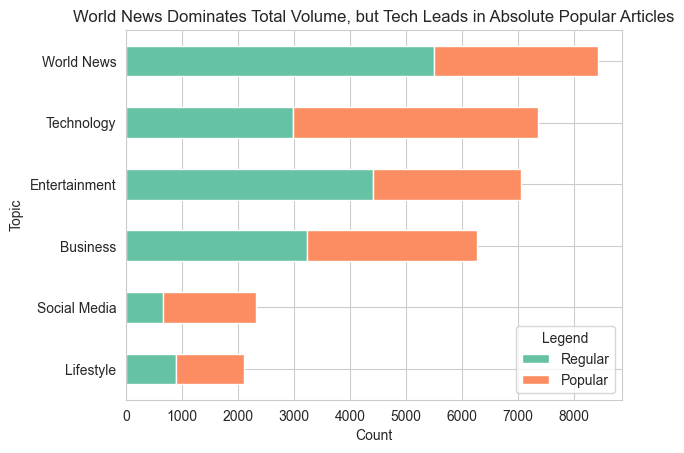

In [6]:
#Creating bar chart for popular vs. regular articles by topic
#Grouping data by topic and aggregating by count
df4=(df2.groupby(['topic','popular'])['url']
     .count()
     .sort_values(ascending=False)
     .reset_index())

#Transforming the data
df4=(df4.pivot(index='topic',columns='popular',values='url')
     .reset_index()
     .rename(columns={0:'regular',1:'popular'}))

df4['total']=df4['regular']+df4['popular'] #Getting total counts by summing counts of regular and popular articles
df4=df4.sort_values(by='total', ascending=False)

totals=df4[['topic','total']]
df4=df4.drop(columns='total')

#Getting colour map
cmap=plt.colormaps['Set2']
color1=cmap.colors[0]
color2=cmap.colors[1]
colors=[color1,color2]

#Plotting Graph
sns.set_style("whitegrid")
labs=['World News','Technology','Entertainment','Business','Social Media','Lifestyle']

fig= df4.set_index('topic').plot(kind='barh',stacked=True,color=colors)
fig.invert_yaxis()
plt.title('World News Dominates Total Volume, but Tech Leads in Absolute Popular Articles')
plt.legend(title='Legend',labels=['Regular','Popular'])
plt.ylabel('Topic')
fig.set_yticklabels(labs)
plt.xlabel('Count')
plt.show()


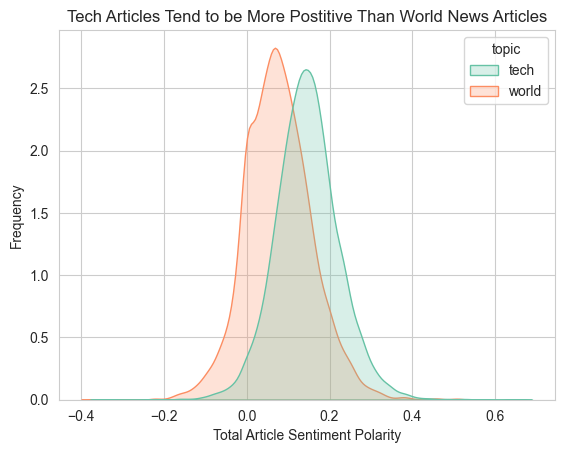

In [7]:
#Creating sentiment KDE plot
df5=df2.copy()

#Filtering for world and tech articles
sns.set_style("whitegrid")
df5=df5[df5['topic'].isin(['world','tech'])]

sns.kdeplot(df5,x='global_sentiment_polarity',hue='topic',fill=True,palette='Set2')
plt.title("Tech Articles Tend to be More Postitive Than World News Articles")
plt.xlabel("Total Article Sentiment Polarity")
plt.ylabel("Frequency")
plt.show()

<Axes: xlabel='log_shares', ylabel='Density'>

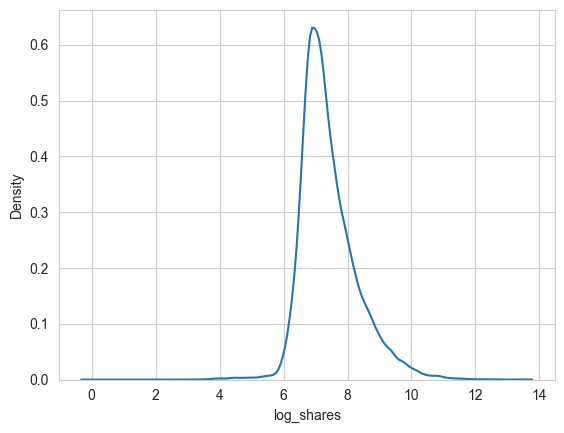

In [8]:
df7=df2.copy()
df7['log_shares']=np.log(df7['shares'])



sns.kdeplot(data=df7,x='log_shares')

/var/folders/85/8clyf79s3t3d0dzbfvhq0b8w0000gn/T/ipykernel_30049/3053844085.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(labs)


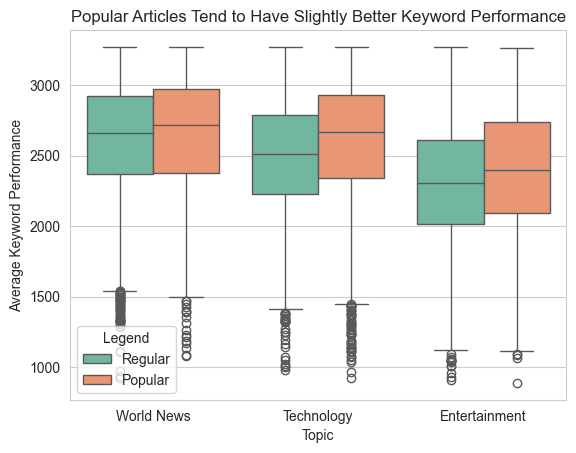

In [9]:
df6=df2.copy()

#Removing Outliers
upper_bound=np.percentile(df6['kw_avg_avg'],75)
lower_bound=np.percentile(df6['kw_avg_avg'],25)
iqr=upper_bound-lower_bound

upperbound=np.percentile(df6['kw_avg_avg'],75)+1.5*iqr
lower_bound=np.percentile(df6['kw_avg_avg'],25)-1.5*iqr

df6 = df6[
    (df6['kw_avg_avg'] >= lower_bound) &
    (df6['kw_avg_avg'] <= upper_bound) #Filter data within the upper and lower bounds
]

#Filtering for top 3 topics
df6=df6[df6['topic'].isin(['world','tech','entertainment'])]

#Plotting box plot
fig=sns.boxplot(data=df6,hue='popular',y='kw_avg_avg',x='topic',palette='Set2')

legend =plt.legend(loc='lower left')

labs=['World News','Technology','Entertainment']

plt.ylabel("Average Keyword Performance")
plt.xlabel("Topic")
legend.set_title("Legend")
legend.texts[0].set_text('Regular')
legend.texts[1].set_text('Popular')
fig.set_xticklabels(labs)
plt.title("Popular Articles Tend to Have Slightly Better Keyword Performance")
plt.show()

<Axes: xlabel='shares', ylabel='topic'>

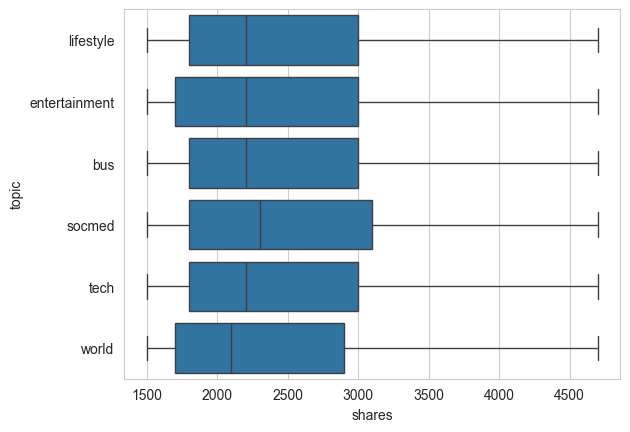

In [10]:
#Creating viral dataset for articles that are popular
df_viral=df2[df2['popular']==1].copy().reset_index()

upper_bound=np.percentile(df_viral['shares'],75)
lower_bound=np.percentile(df_viral['shares'],25)
iqr=upper_bound-lower_bound

upperbound=np.percentile(df_viral['shares'],75)+1.5*iqr
lower_bound=np.percentile(df_viral['shares'],25)-1.5*iqr

df_viral = df_viral[
    (df_viral['shares'] >= lower_bound) &
    (df_viral['shares'] <= upper_bound)
]

sns.boxplot(df_viral,x='shares',y='topic')

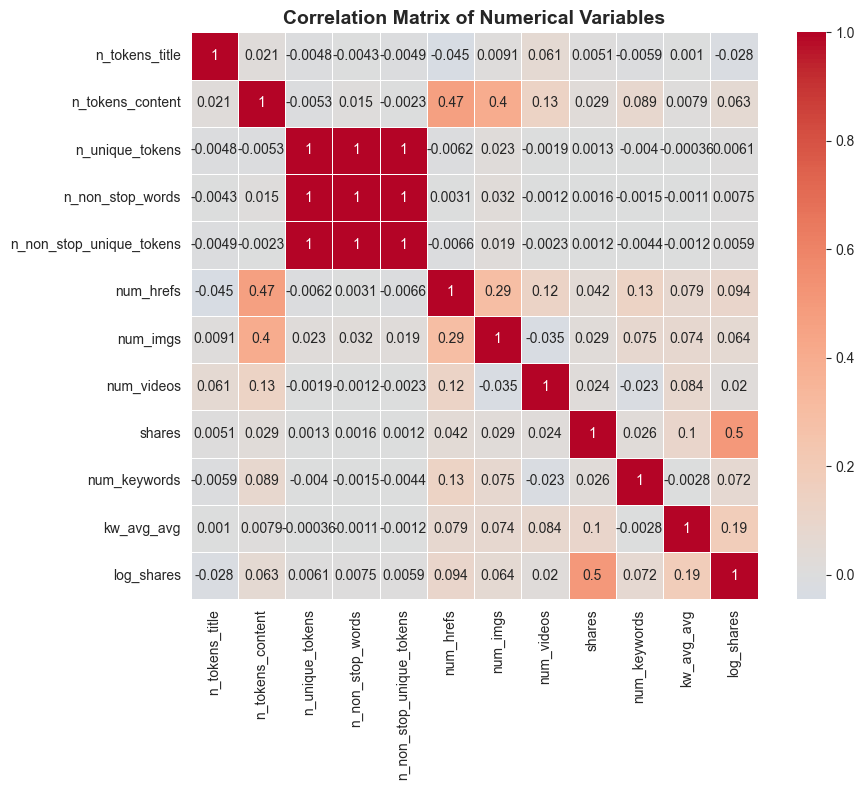

In [11]:
#Getting Numerical values only
df_num=df2.copy()
df_num=df_num[['n_tokens_title','n_tokens_content','n_unique_tokens',
               'n_non_stop_words','n_non_stop_unique_tokens',
               'num_hrefs','num_imgs','num_videos','shares',
               'num_keywords','kw_avg_avg']]

df_num['log_shares']=np.log(df_num['shares'])

# Create correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df_num.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [12]:
from sklearn.preprocessing import StandardScaler

df_cluster=df_viral.copy()

drop_cols=['weekday','topic','url','shares','index']

df_cluster_cols=[c for c in df_cluster.columns.tolist() if c not in drop_cols]
df_cluster=df_cluster[df_cluster_cols]
print(df_cluster_cols)

scaler = StandardScaler()

df_scaled=scaler.fit_transform(df_cluster)
df_scaled=pd.DataFrame(df_scaled, columns= df_cluster_cols)

['timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'is_weekend', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity', 'max_positive_polarity', 'avg_negative_polarity', 'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity', 'title_sentiment_polarity', 'abs_title_subjectivity', 'abs_title_sentiment_polarity', 'popular']


[11734   181]


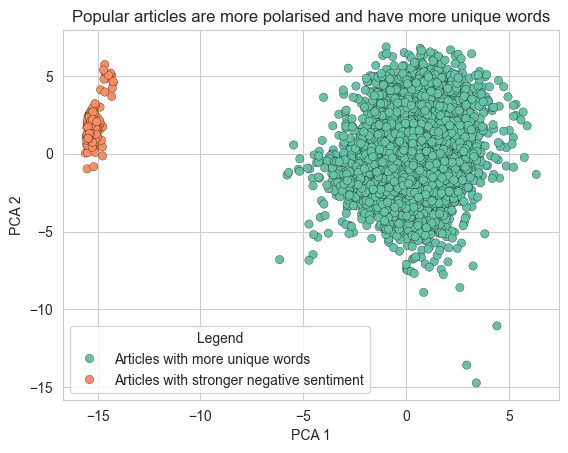

In [13]:
from sklearn.cluster import KMeans 

#Creating clusters using K-means clustering
cluster_news=KMeans(n_clusters=2, n_init=50, random_state=69).fit(df_scaled)
cluster_news_labels=cluster_news.labels_
unique, counts = np.unique(cluster_news_labels, return_counts=True)

print(counts)

#Dimension reduction for visualisation via PCA
from sklearn.decomposition import PCA

pca=PCA(2, random_state=69)
cluster_pca= pca.fit_transform(df_scaled.values) #Reducing multidimensional data to 2 dimensions

pca1=np.array(cluster_pca[:,0]) #Extracting PCA 1
pca2=np.array(cluster_pca[:,1]) #Extracting PCA 2

#Ploting graph
sns.set_style("whitegrid")
sns.scatterplot(x=pca1,y=pca2,hue=cluster_news_labels,palette='Set2',linewidth=0.2, edgecolor='black')
plt.title("Popular articles are more polarised and have more unique words")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

legend =plt.legend()
legend.set_title("Legend")
legend.texts[0].set_text('Articles with more unique words')
legend.texts[1].set_text('Articles with stronger negative sentiment')
plt.show()

In [14]:
#Checking articles in each cluster
#Cluster 1: Articles with more unique words
#Cluster 2: Articles with greater negative sentiment
df_viral2=df_viral.copy()
pd.set_option('display.max_colwidth', None)

df_viral2['k_clusters']=cluster_news_labels
df_viral2[df_viral2['k_clusters']==1]['url']

156                          http://mashable.com/2014/09/21/text-message-history/
162                            http://mashable.com/2014/10/25/resume-hard-truths/
189                          http://mashable.com/2013/02/05/online-dating-habits/
191               http://mashable.com/2013/02/05/teachers-technology-infographic/
345                        http://mashable.com/2014/11/10/shake-up-daily-routine/
                                           ...                                   
15711    http://mashable.com/2014/07/05/neymar-injury-video-world-cup-fans-react/
15761                  http://mashable.com/2014/09/27/climate-change-stats-video/
15789                         http://mashable.com/2014/11/07/french-fries-pop-up/
15824                         http://mashable.com/2014/12/24/drake-holiday-cards/
15825            http://mashable.com/2014/12/24/loyal-dog-chases-after-ambulance/
Name: url, Length: 181, dtype: object

/Users/neelabjo1103/my-project/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


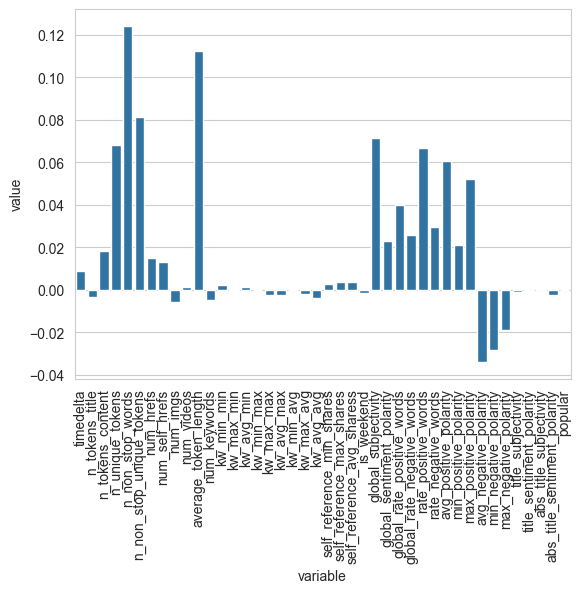

In [15]:
#Profile analysis

k3_center_df=pd.DataFrame(cluster_news.cluster_centers_,columns=df_cluster_cols)

k3_center_df['cluster']=np.arange(1, k3_center_df.shape[0]+1)
k3_center_long=k3_center_df.melt(id_vars='cluster',var_name='variable',value_name='value')
k3_center_long['log_value']=np.log1p(k3_center_long['value'])


sns.barplot(data=k3_center_long[k3_center_long['cluster']==1],x='variable',y='value')


plt.xticks(rotation=90)
plt.show()

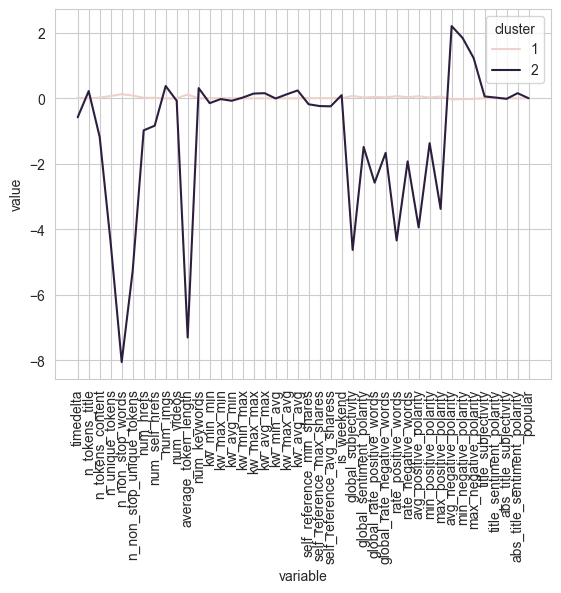

In [16]:
#Profile Analysis: lineplot
sns.lineplot(data=k3_center_long,x='variable',y='value',hue='cluster')
plt.xticks(rotation=90)
plt.show()

In [17]:
from sklearn.metrics import silhouette_score, silhouette_samples
sil_avgs={}
for k in [2, 3, 4, 5,6,7]:
    # Run K-Means with k clusters
    km = KMeans(n_clusters=k, n_init=50, random_state=42).fit(df_scaled)
    labels = km.labels_  # Get cluster labels

    # Calculate average silhouette score
    # silhouette_score calculates the average for all points
    sil = silhouette_score(df_scaled, labels)
    sil_avgs[k] = sil  # Store the score

    # Print the result
    print(f"k={k}: Average silhouette score = {sil:.3f}")

k=2: Average silhouette score = 0.564
k=3: Average silhouette score = 0.084
k=4: Average silhouette score = 0.091
k=5: Average silhouette score = 0.094
k=6: Average silhouette score = 0.093
k=7: Average silhouette score = 0.094


Testing k values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

k= 1: WSS = 488,515.00
k= 2: WSS = 440,055.76
k= 3: WSS = 410,896.55
k= 4: WSS = 386,433.34
k= 5: WSS = 367,549.08
k= 6: WSS = 346,962.89
k= 7: WSS = 334,745.06
k= 8: WSS = 319,745.98
k= 9: WSS = 311,744.85
k=10: WSS = 302,001.60



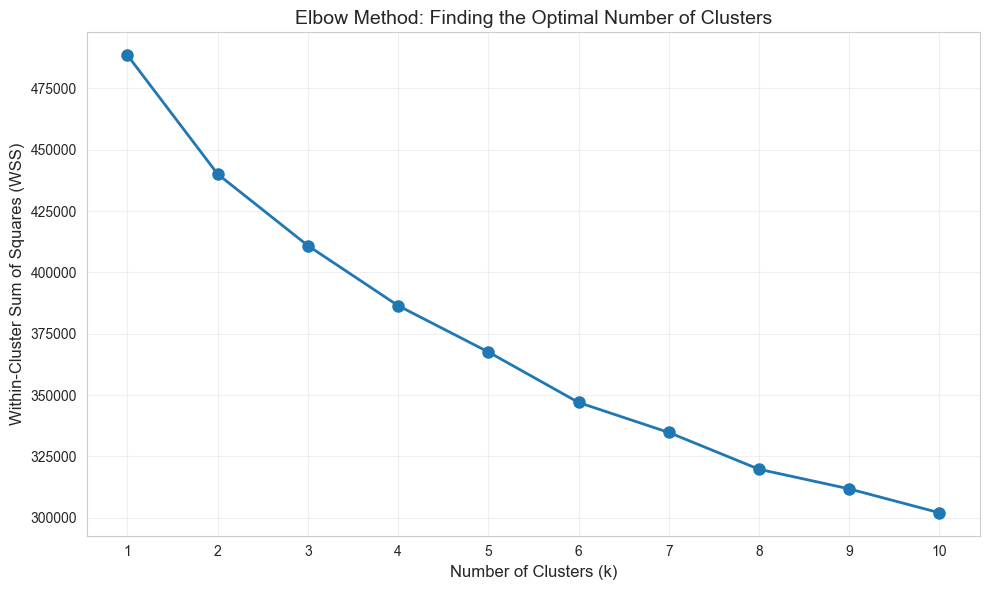

CHANGE IN WSS (helping find the elbow):
k=1 to k=2: WSS decreased by 48,459.24 (9.9%)
k=2 to k=3: WSS decreased by 29,159.21 (6.6%)
k=3 to k=4: WSS decreased by 24,463.21 (6.0%)
k=4 to k=5: WSS decreased by 18,884.25 (4.9%)
k=5 to k=6: WSS decreased by 20,586.19 (5.6%)
k=6 to k=7: WSS decreased by 12,217.82 (3.5%)
k=7 to k=8: WSS decreased by 14,999.08 (4.5%)
k=8 to k=9: WSS decreased by 8,001.14 (2.5%)
k=9 to k=10: WSS decreased by 9,743.24 (3.1%)



In [18]:

# We'll try k from 1 to 10
ks = list(range(1, 11))  # [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
print(f"Testing k values: {ks}")
print()

# STEP 2: Calculate WSS for each value of k
# WSS = Within-cluster Sum of Squares (how tight the clusters are)
# Lower WSS = tighter clusters (better)
sse = []  # List to store WSS values

for k in ks:
    # Run K-Means with k clusters
    km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(df_scaled)

    # Get the WSS (inertia_ is the WSS)
    wss = km.inertia_
    sse.append(wss)

    print(f"k={k:2d}: WSS = {wss:,.2f}")

print()

# STEP 3: Create the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(ks, sse, marker='o', linewidth=2, markersize=8)  # Plot WSS vs k
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WSS)', fontsize=12)
plt.title('Elbow Method: Finding the Optimal Number of Clusters', fontsize=14)
plt.xticks(ks)  # Show all k values on x-axis
plt.grid(True, alpha=0.3)  # Add grid for easier reading
plt.tight_layout()  # Adjust spacing
plt.show()  # Display the plot

# STEP 4: Calculate and show the "elbow" (change in WSS)
print("=" * 60)
print("CHANGE IN WSS (helping find the elbow):")
print("=" * 60)
for i in range(1, len(sse)):
    change = sse[i-1] - sse[i]  # How much WSS decreased
    percent_change = (change / sse[i-1]) * 100  # Percentage decrease
    print(f"k={i} to k={i+1}: WSS decreased by {change:,.2f} ({percent_change:.1f}%)")
print()


In [19]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster  # Hierarchical clustering
from scipy.spatial.distance import pdist, squareform  # Distance calculations

hc_k = 2  # match the lecture default for easy comparison

# STEP 1: Pairwise Euclidean distances (condensed vector form)
distance_condensed = pdist(df_scaled, metric="euclidean")

# STEP 2: Ward linkage dendrogram (minimises increase in within-cluster variance)
hc_linkage = linkage(distance_condensed, method="ward")

# STEP 3: Cut the dendrogram to obtain flat clusters
ehc_labels = fcluster(hc_linkage, t=hc_k, criterion="maxclust")

# STEP 4: Summaries and diagnostics
cluster_sizes = np.bincount(ehc_labels, minlength=hc_k + 1)[1:]
print(cluster_sizes)

[  181 11734]


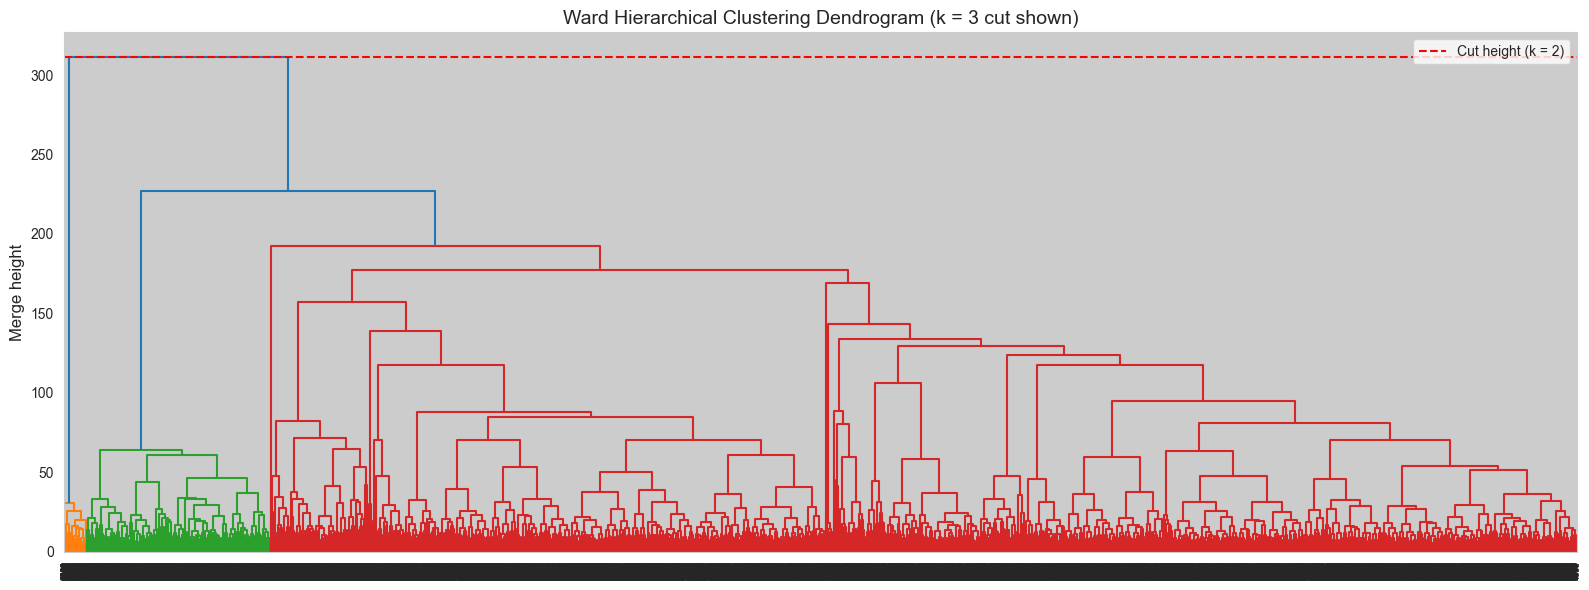

In [20]:
plt.figure(figsize=(16, 6))
dendrogram(
    hc_linkage,
    labels=df_viral["shares"].values,
    leaf_rotation=90,
    leaf_font_size=6,
    color_threshold=None
)
plt.title("Ward Hierarchical Clustering Dendrogram (k = 3 cut shown)", fontsize=14)
plt.ylabel("Merge height", fontsize=12)

# Highlight the cut level that yields k clusters
cut_height = hc_linkage[-(hc_k - 1), 2] if hc_k > 1 else hc_linkage[-1, 2]
plt.axhline(y=cut_height, color="red", linestyle="--", linewidth=1.5, label=f"Cut height (k = {hc_k})")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

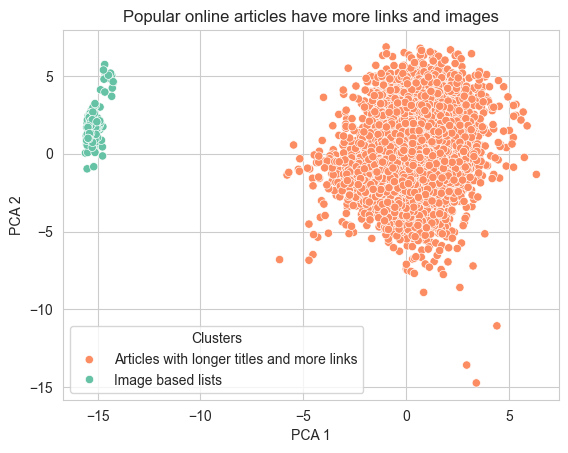

In [21]:
pca=PCA(2, random_state=69)
cluster_pca= pca.fit_transform(df_scaled.values)

pca1=np.array(cluster_pca[:,0])
pca2=np.array(cluster_pca[:,1])

sns.scatterplot(x=pca1,y=pca2,hue=ehc_labels,palette='Set2')

plt.title("Popular online articles have more links and images")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Clusters', 
           loc='lower left', 
           labels=['Articles with longer titles and more links','Image based lists']
           )
plt.show()

Top variables: ['self_reference_max_shares', 'self_reference_avg_sharess', 'self_reference_min_shares', 'n_tokens_content', 'num_hrefs', 'average_token_length', 'num_self_hrefs', 'min_negative_polarity', 'n_non_stop_words', 'max_positive_polarity', 'rate_positive_words', 'n_non_stop_unique_tokens', 'num_imgs', 'kw_min_min', 'n_unique_tokens']


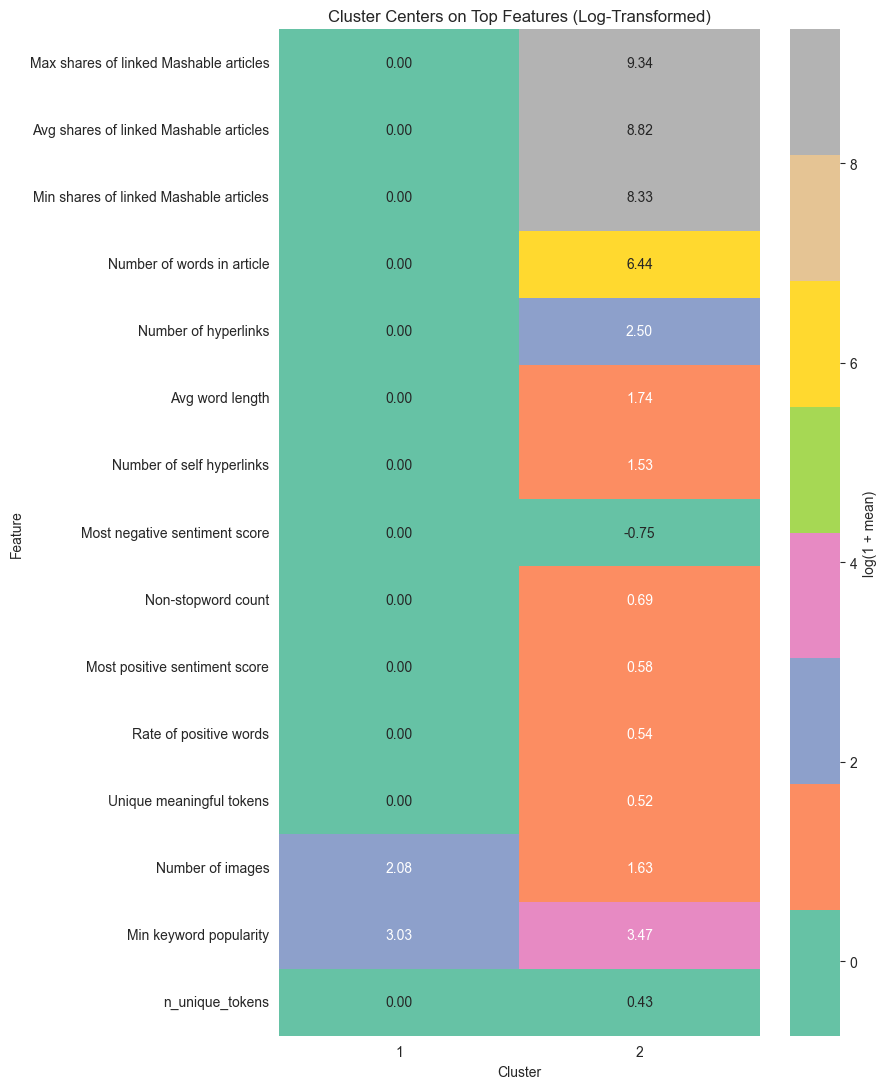

In [38]:
# ============================
# CLUSTER PROFILES – HEATMAP (LOG SCALE) WITH HUMAN-FRIENDLY LABELS
# ============================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 0) Mapping from original variable names → human-friendly descriptive labels
friendly_names = {
    "self_reference_max_shares": "Max shares of linked Mashable articles",
    "self_reference_avg_sharess": "Avg shares of linked Mashable articles",
    "self_reference_min_shares": "Min shares of linked Mashable articles",
    "n_tokens_content": "Number of words in article",
    "num_hrefs": "Number of hyperlinks",
    "average_token_length": "Avg word length",
    "num_self_hrefs": "Number of self hyperlinks",
    "min_negative_polarity": "Most negative sentiment score",
    "n_non_stop_words": "Non-stopword count",
    "max_positive_polarity": "Most positive sentiment score",
    "rate_positive_words": "Rate of positive words",
    "n_non_stop_unique_tokens": "Unique meaningful tokens",
    "num_imgs": "Number of images",
    "kw_min_min": "Min keyword popularity",
    "kw_avg_max": "Avg keyword max popularity",
    "kw_max_max": "Max keyword max popularity",
    "kw_min_max": "Max keyword min popularity",
    "kw_avg_avg": "Avg keyword popularity",
    "kw_max_avg": "Avg max keyword pop.",
    "kw_max_min": "Min keyword max popularity",
    "kw_avg_min": "Min avg keyword popularity",
    "kw_min_avg": "Avg min keyword popularity",
    "timedelta": "Age of article (days)"
}

# 1) Compute cluster centres
hc_centers = (
    df_viral.assign(cluster=ehc_labels)
    .groupby("cluster")[df_cluster_cols]
    .mean()
)

# 2) Log-transform cluster centres
hc_log = np.log1p(hc_centers)

# 3) Select top 15 distinguishing variables
feature_diff = hc_log.std(axis=0)
top_vars = feature_diff.sort_values(ascending=False).head(15).index
print("Top variables:", list(top_vars))

hc_log_top = hc_log[top_vars]

# 4) Replace variable names with human-friendly versions
hc_log_top_friendly = hc_log_top.copy()
hc_log_top_friendly.columns = [
    friendly_names.get(col, col) for col in hc_log_top_friendly.columns
]

# 5) Plot heatmap
plt.figure(figsize=(9, 11))
sns.heatmap(
    hc_log_top_friendly.T,
    annot=True,
    fmt=".2f",
    cmap=plt.colormaps['Set2'],
    cbar_kws={"label": "log(1 + mean)"}
)

plt.title("Cluster Centers on Top Features (Log-Transformed)")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Shape of X: (33510, 52)
Shape of y: (33510,)
Random Forest fitted!
Train accuracy: 0.866868099074903
Test accuracy: 0.6789018203521336

Classification report:

              precision    recall  f1-score   support

     Regular       0.68      0.73      0.71      3537
     Popular       0.67      0.62      0.65      3165

    accuracy                           0.68      6702
   macro avg       0.68      0.68      0.68      6702
weighted avg       0.68      0.68      0.68      6702

Confusion matrix:

[[2585  952]
 [1200 1965]]


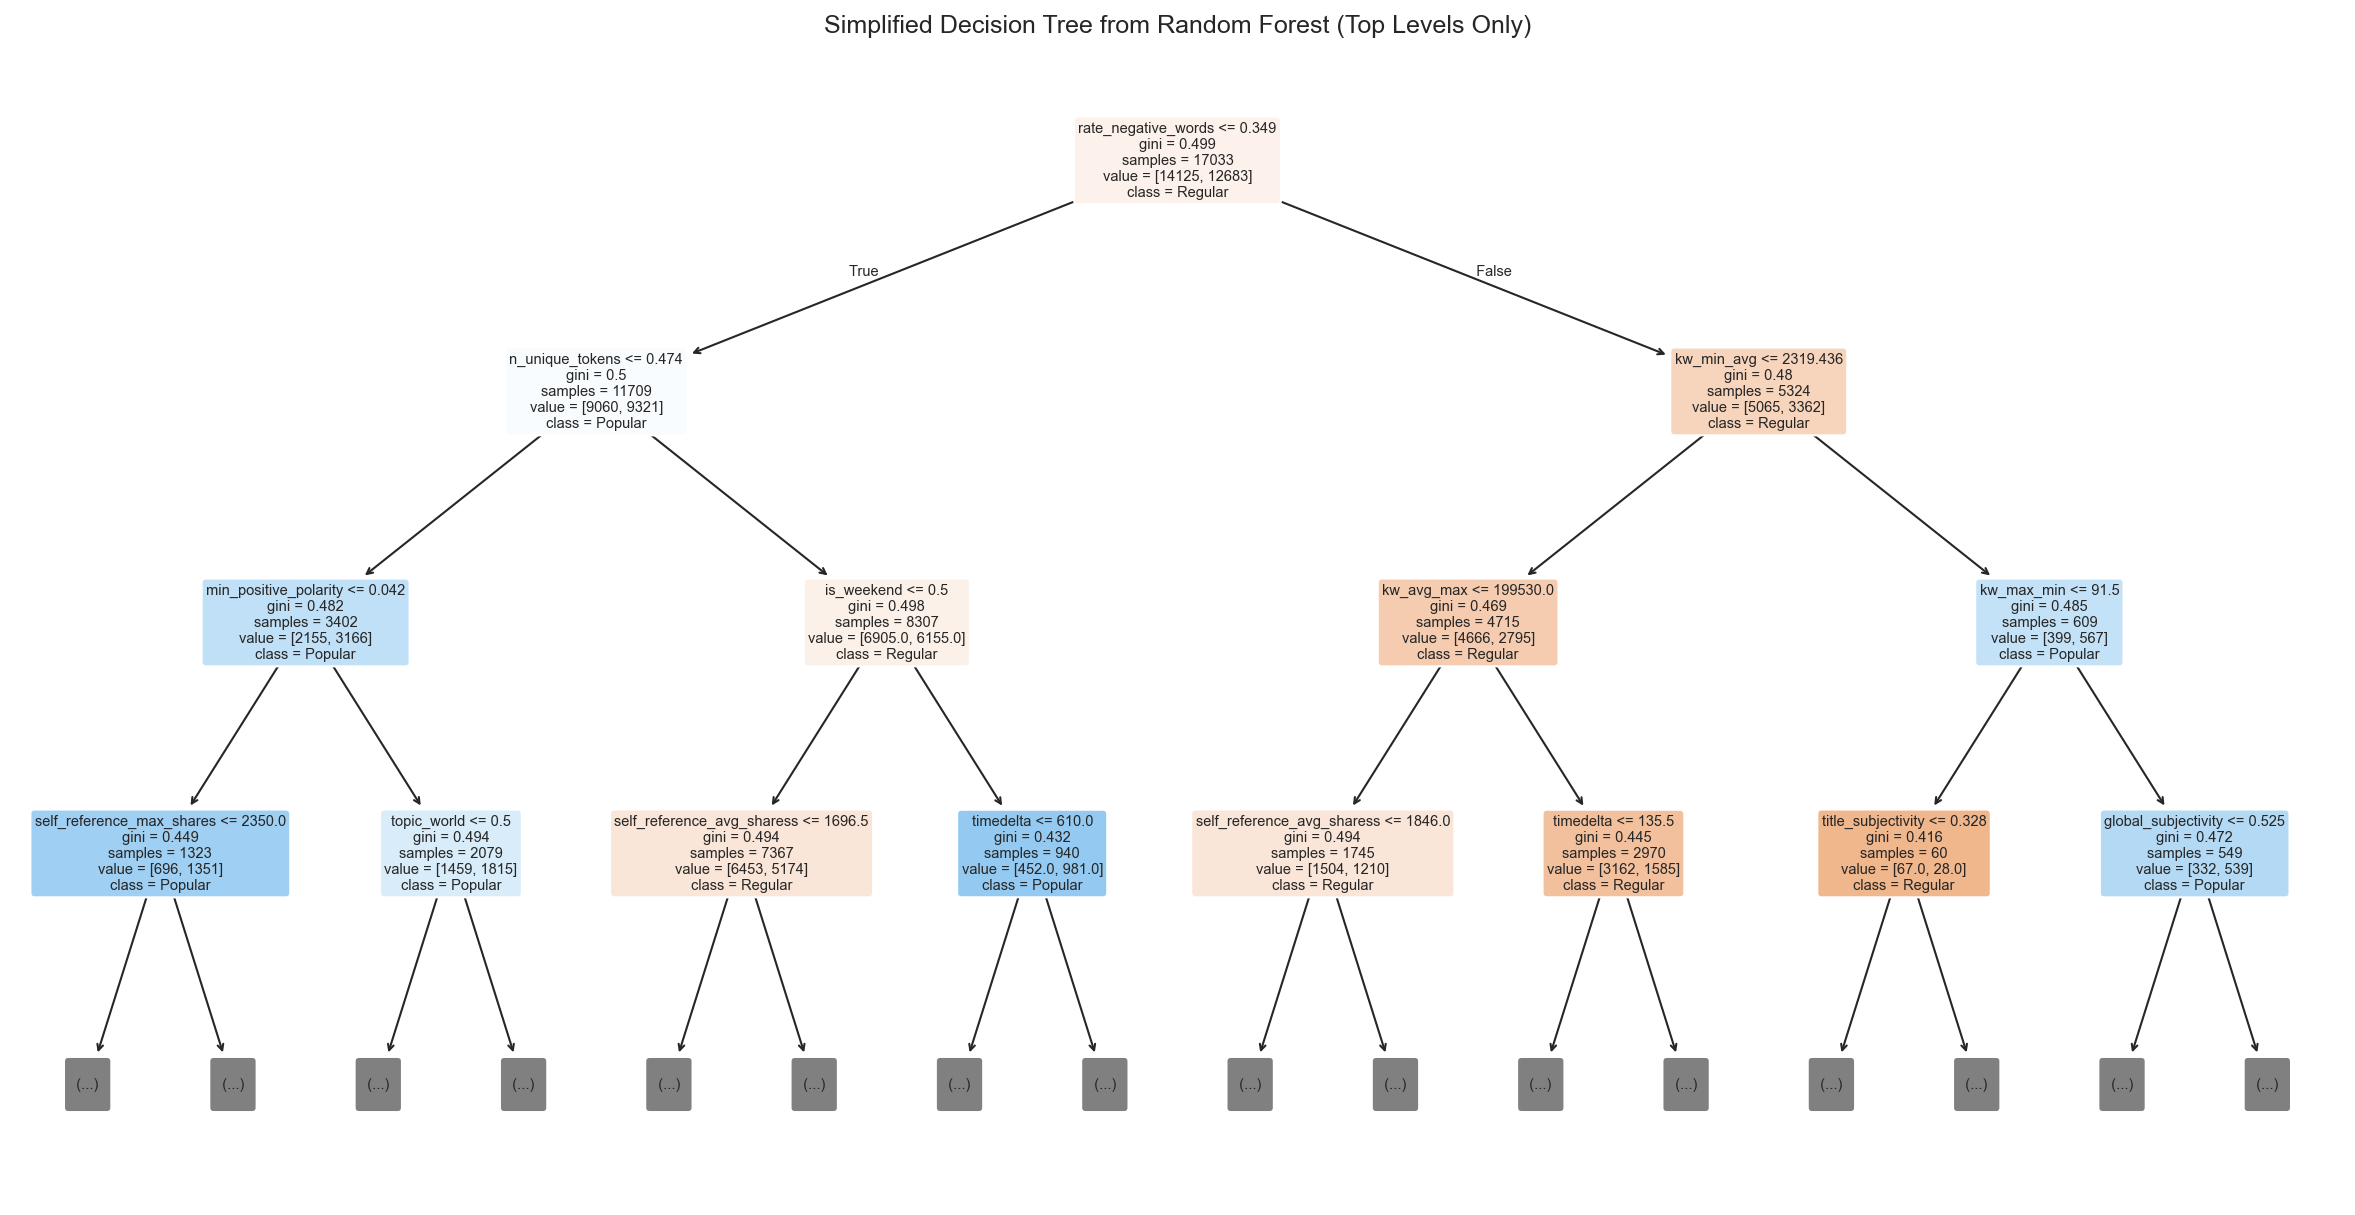

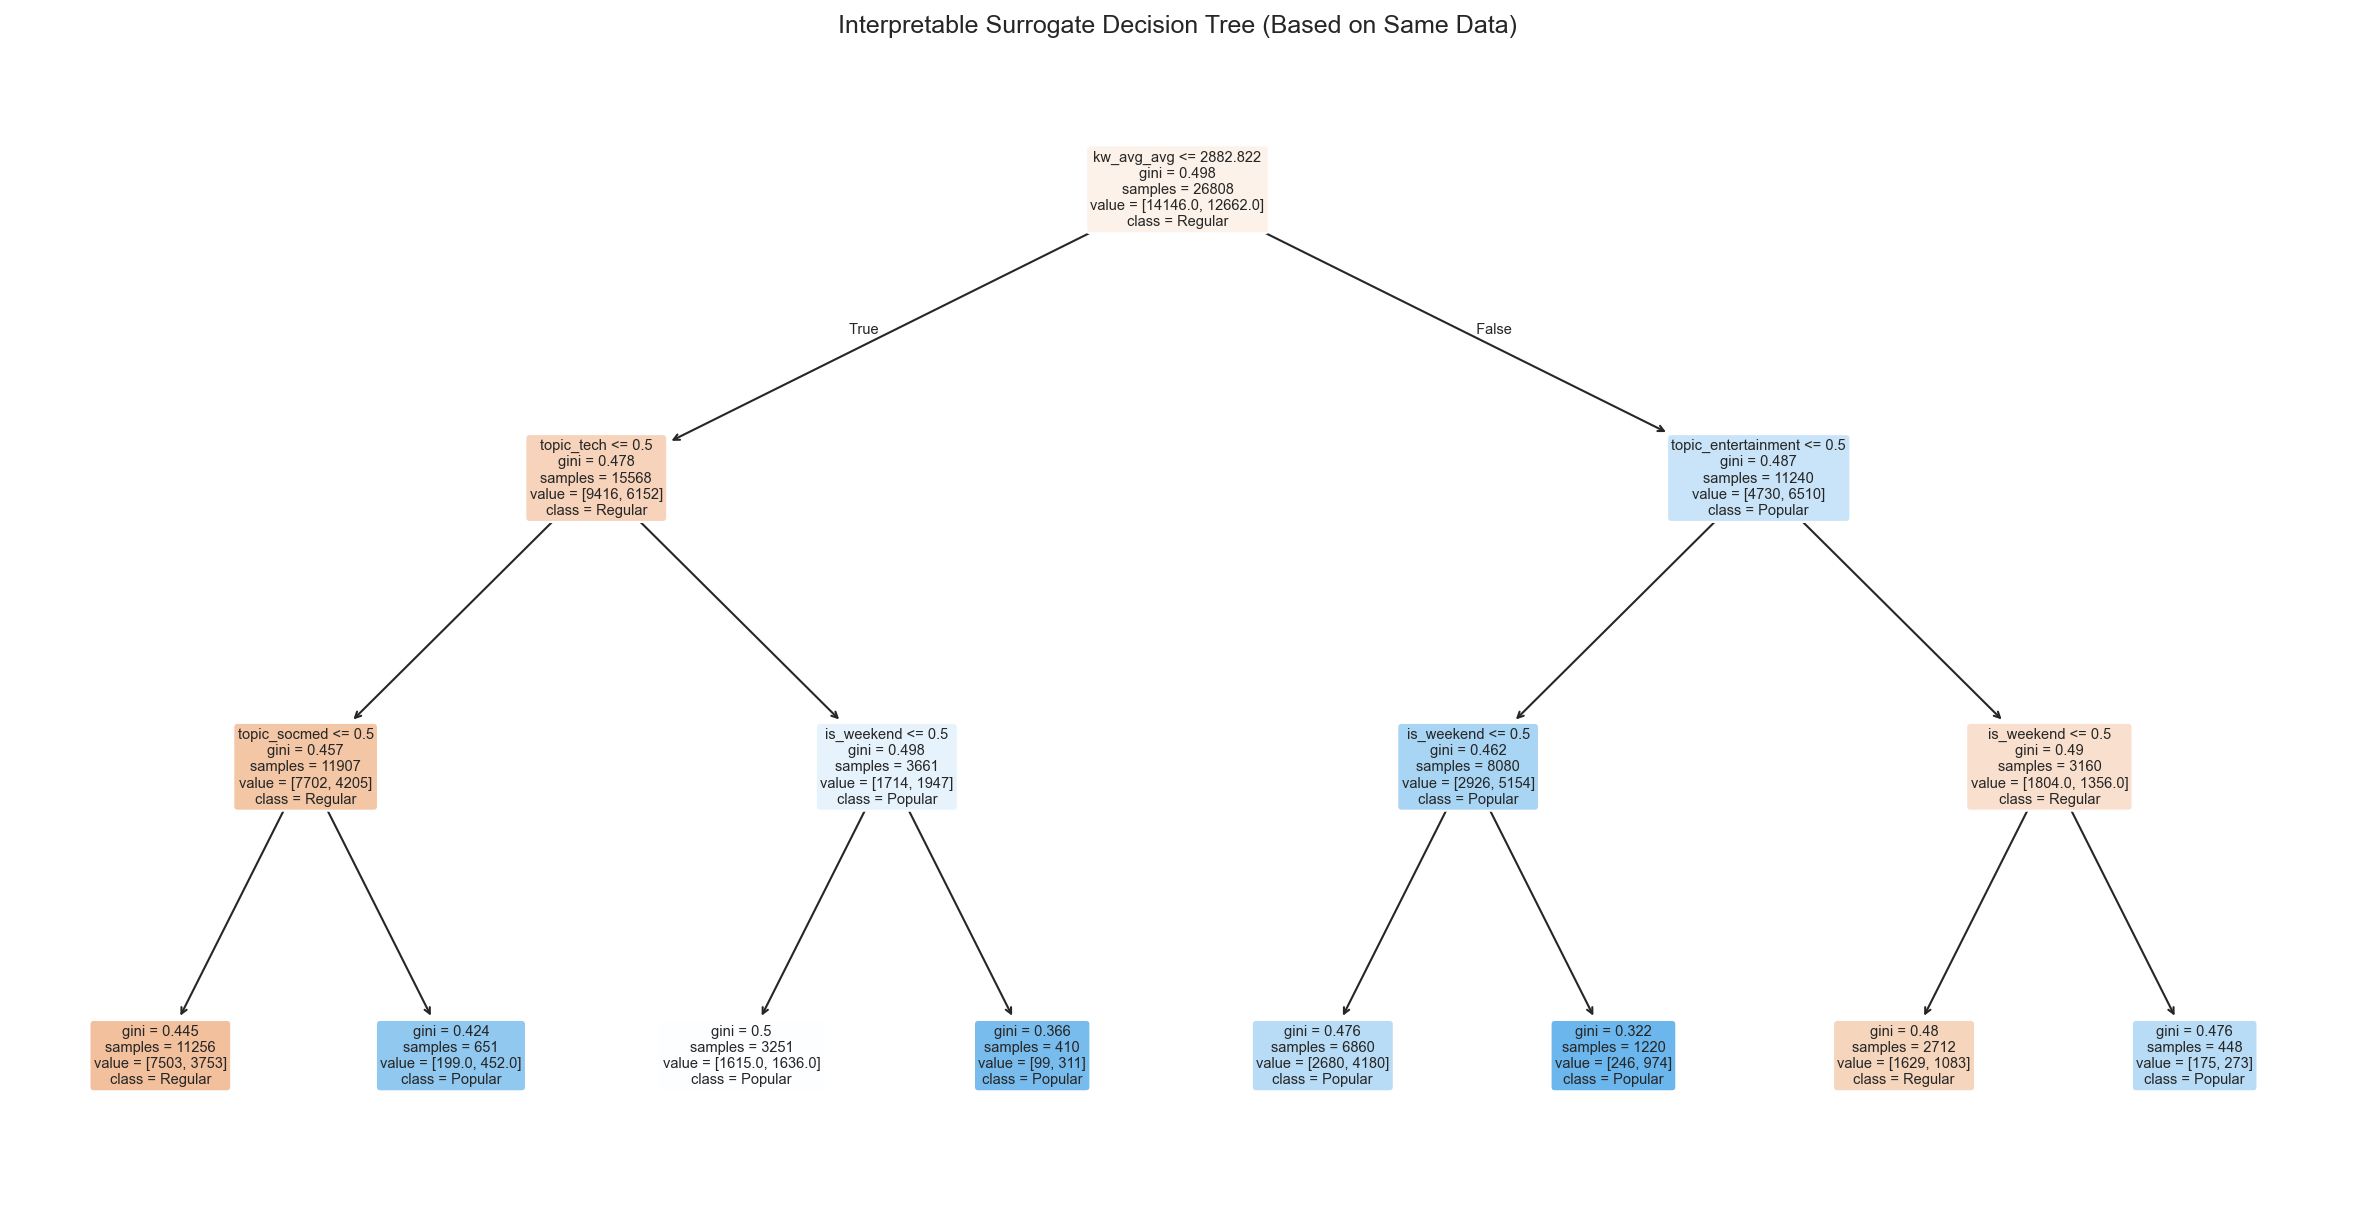

In [ ]:
# ============================
# RANDOM FOREST + VISUALISATIONS
# ============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1) -------- Prepare data --------
# Start from df2, which already has 'popular' defined
rf_df = df2.copy()

# Target variable
y = rf_df['popular']

# Drop columns that should NOT be used as predictors (only if they exist)
drop_cols = [c for c in ['url', 'shares', 'popular'] if c in rf_df.columns]
rf_df = rf_df.drop(columns=drop_cols)

# One-hot encode categorical variables (weekday, topic) if they exist
cat_cols = [c for c in ['weekday', 'topic'] if c in rf_df.columns]
rf_df = pd.get_dummies(rf_df, columns=cat_cols, drop_first=True)

X = rf_df

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 2) -------- Train Random Forest --------
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)


rf_clf.fit(X_train, y_train)

print("Random Forest fitted!")
print("Train accuracy:", rf_clf.score(X_train, y_train))
print("Test accuracy:", rf_clf.score(X_test, y_test))

# 3) -------- Evaluation --------
y_pred = rf_clf.predict(X_test)

print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=['Regular', 'Popular']))

print("Confusion matrix:\n")
print(confusion_matrix(y_test, y_pred))

# 4) -------- Visualise: simplified tree from Random Forest --------
# Pick one estimator from the forest
estimator = rf_clf.estimators_[0]

plt.figure(figsize=(20, 10), dpi=150)
plot_tree(
    estimator,
    feature_names=X.columns,
    class_names=['Regular', 'Popular'],  # assuming 0 = Regular, 1 = Popular
    filled=True,
    rounded=True,
    fontsize=7,
    max_depth=3        # << key: only show top 3 levels so it isn't insane
)
plt.title("Simplified Decision Tree from Random Forest (Top Levels Only)")
plt.show()

# 5) -------- Visualise: small surrogate Decision Tree --------
# (Purely for interpretation, not used for prediction)
viz_tree = DecisionTreeClassifier(
    max_depth=3,         # keep shallow for readability
    min_samples_leaf=50, # avoid tiny noisy leaves
    random_state=42
)

viz_tree.fit(X_train, y_train)

plt.figure(figsize=(20, 10), dpi=150)
plot_tree(
    viz_tree,
    feature_names=X.columns,
    class_names=['Regular', 'Popular'],
    filled=True,
    rounded=True,
    fontsize=7
)
plt.title("Interpretable Surrogate Decision Tree (Based on Same Data)")
plt.show()
